In [2]:
import re
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import pysam
from pyBioInfo.Range import GRange
from pyBioInfo.IO.File import BedFile
from pyBioInfo.Utils import ShiftLoader, SegmentTools
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Make benchmark callset and regions for NA12878

In [52]:
dats = pd.read_excel("data/inversions_from_cell_paper.xlsx", sheet_name=None)
dat = dats["2AGRCh38_unifiedCallset"]
dat = dat[dat["seqnames"] != "chrY"]
counter = Counter(dat["NA12878"])
items = sorted(counter.items(), key=lambda item: item[1], reverse=True)
for k, v in items:
    print(v, k, sep="\t")

161	0|0
74	1|1
25	1|0
22	0|0_lowconf
22	0|1
17	noreads
9	0000
8	idup_hom
7	2110
5	0|1_lowconf
4	1000
4	0100
3	1100
3	1|1_lowconf
2	1021
2	0001
2	0021
2	1201
2	1101
2	1|0_lowconf
1	idup_h2
1	0112
1	3100
1	0011
1	0010
1	0200
1	0202


In [53]:
invs = [] # NA12878
blacklist = [] # blacklist
for chrom, start, end, name, gt in dat[["seqnames", "start", "end", "inv_id", "NA12878"]].values:
    inv = GRange(chrom=chrom, start=start, end=end, name="%s:NA12878=%s" % (name, gt), strand="+")
    inv.gt = gt
    if gt in ["1|1", "0|1", "1|0"]:
        invs.append(inv)
    elif gt == "0|0":
        continue
    else:
        blacklist.append(inv)
print("NA12878:", len(invs))
print("Blacklist:", len(blacklist))

NA12878: 121
Blacklist: 101


In [54]:
with open("results/cell_paper_inv_na12878.bed", "w+") as f:
    for x in invs:
        f.write(x.format() + "\n")
with open("results/cell_paper_inv_na12878.blacklist.bed", "w+") as fw:
    for x in blacklist:
        fw.write(x.format() + "\n")

# Inversion from cuteSV 

In [55]:
f_vcf = "../../4_NanoStrandseq_Assembly/results/HG001_Cell_350/prepare/all_cells.all_chroms.raw.cutesv.vcf.gz"
invs = []
dups = []
with pysam.VariantFile(f_vcf) as f:
    for record in f:
        if re.match("^chr([0-9]+|[X])$", record.contig) is None:
            continue
        svtype = record.info["SVTYPE"]
        if svtype == "INV":            
            if record.info["RE"] < 3:
                continue
            af = record.info["AF"][0]
            if af is None or af < 0.2:
                continue
            obj = GRange(chrom=record.contig, start=record.start, end=record.stop, name=record.id)
            obj.record = record
            if len(obj) < 200:
                continue
            invs.append(obj)
        elif svtype == "DUP":
            if list(record.filter)[0] != "PASS":
                continue
            obj = GRange(chrom=record.contig, start=record.start, end=record.stop, name=record.id)
            obj.record = record
            if len(obj) < 200:
                continue
            dups.append(obj)
invs.sort()
dups.sort()

print("Loaded inversions:", len(invs))
print("Loaded duplicates:", len(dups))

Loaded inversions: 2253
Loaded duplicates: 433


In [100]:
with open("results/cuteSV_dup_na12878.pass.bed", "w+") as fw:
    for x in dups:
        fw.write(x.format() + "\n")

In [57]:
loader = ShiftLoader(dups)
tmp = []
for inv in invs:
    hit = False
    for dup in loader.fetch(obj=inv):
        start, end = max(inv.start, dup.start), min(inv.end, dup.end)
        overlap = end - start
        length = min(len(inv), len(dup))
        r = overlap / length
        if overlap >= 200 or r > 0.3:
            hit = True
    if hit:
        print(inv.format())
    else:
        tmp.append(inv)
print("Inversions:", len(tmp))

invs_filtered = tmp

chr1	143194985	143214200	cuteSV.INV.4834	.	None	143194985	143194985	255,0,0	1	19215,	0,
chr1	143211365	143242899	cuteSV.INV.4861	.	None	143211365	143211365	255,0,0	1	31534,	0,
chr12	34769408	34820286	cuteSV.INV.20406	.	None	34769408	34769408	255,0,0	1	50878,	0,
chr12	34820185	34822288	cuteSV.INV.20409	.	None	34820185	34820185	255,0,0	1	2103,	0,
chr16	36312446	36313679	cuteSV.INV.35184	.	None	36312446	36312446	255,0,0	1	1233,	0,
chr2	90384367	90397001	cuteSV.INV.49158	.	None	90384367	90384367	255,0,0	1	12634,	0,
chr20	1838854	1906269	cuteSV.INV.54748	.	None	1838854	1838854	255,0,0	1	67415,	0,
chr21	10269881	10324332	cuteSV.INV.57418	.	None	10269881	10269881	255,0,0	1	54451,	0,
chr21	10271218	10360054	cuteSV.INV.57419	.	None	10271218	10271218	255,0,0	1	88836,	0,
chr21	10273487	10360055	cuteSV.INV.57420	.	None	10273487	10273487	255,0,0	1	86568,	0,
chr21	43262474	43336016	cuteSV.INV.58538	.	None	43262474	43262474	255,0,0	1	73542,	0,
chr4	49487143	49558934	cuteSV.INV.69475	.	None	49487143	4

In [99]:
loader = ShiftLoader(invs_filtered)
n = 0
with BedFile("results/cell_paper_inv_na12878.bed") as f:
    for inv in f:
        if len(list(loader.fetch(obj=inv))) == 0:
            n += 1
            # print(inv.format())
print(n)

82


In [67]:
def get_clips(cigars):
    c1, c2 = 0, 0
    if cigars[0][0] in ["S", "H"]:
        i1, i2 = cigars[0][2]
        c1 = i2 - i1
    if cigars[-1][0] in ["S", "H"]:
        i1, i2 = cigars[-1][2]
        c2 = i2 - i1
    return c1, c2

def get_query_length(cigars):
    return cigars[-1][2][1]

def get_read_index(cigars, length, strand):
    c1, c2 = get_clips(cigars)
    i1, i2 = c1, length - c2
    if strand == "-":
        i1, i2 = length - i2, length - i1
    return i1, i2

def check_segments(segments):
    n = len(segments)
    assert n == 2 or n == 3
    segments = list(sorted(segments, key=lambda s: s.reference_start))
    strands = ["+" if s.is_forward else "-" for s in segments]
    locs = [(s.reference_start, s.reference_end) for s in segments]
    cigars_list = [SegmentTools.parse_cigar(s) for s in segments]
    length = get_query_length(cigars_list[0])
    indexs_list = [get_read_index(cigars, length, strand) for cigars, strand in zip(cigars_list, strands)]
    
    if strands[0] == strands[1]:
        return False
    if n ==3 and strands[1] == strands[2]:
        return False
    
    if n == 2:
        if locs[0][1] - 10 >= locs[1][0]:
            return False
    else:
        if abs(locs[1][0] - locs[0][1]) >= 20 or abs(locs[2][0] - locs[1][1]) >= 20:
            return False
        
    
    if n == 2:
        (i1, i2), (i3, i4) = indexs_list
        if i1 > i3:
            i1, i2, i3, i4 = i3, i4, i1, i2
        if i1 > 99999999:
            return False
        if abs(i2 - i3) > 100:
            return False
        if length - i4 > 99999999:
            return False
    else:
        (i1, i2), (i3, i4), (i5, i6) = indexs_list
        if i1 >= i5:
            i1, i2, i5, i6 = i5, i6, i1, i2
        
        if i1 > 99999999:
            return False
        if abs(i2 - i3) > 100:
            return False
        if abs(i4 - i5) > 100:
            return False
        if length - i6 > 99999999:
            return False
        
    return True


In [68]:
f_bam = "../../4_NanoStrandseq_Assembly/results/HG001_Cell_350/prepare/all_cells.all_chroms.raw.bam"
with pysam.AlignmentFile(f_bam) as f:
    for i, inv in enumerate(invs_filtered):            
        if i % 100 == 0:
            print(i)
            
        segments = defaultdict(list)
        for s in f.fetch(inv.chrom, inv.start - 500, inv.end + 500):
            if s.is_secondary:
                continue
            segments[s.query_name].append(s)
            
        rnames = inv.record.info["RNAMES"]
        
        support_reads = 0
        support_read_groups = []
        support_complexity = 0
        
        for rname in rnames:
            ss = segments[rname]
            if len(ss) == 0:
                continue
            rg = ss[0].get_tag("RG")
            if len(ss) == 1:
                continue
            elif len(ss) == 2:
                if check_segments(ss):
                    support_reads += 1
                    support_read_groups.append(rg)
                else:
                    support_complexity += 1
            elif len(ss) == 3:
                if check_segments(ss):
                    support_reads += 1
                    support_read_groups.append(rg)
                else:
                    support_complexity += 1
            else:
                support_complexity += 1
                
        inv.support_reads = support_reads
        inv.support_read_groups = support_read_groups
        inv.support_complexity = support_complexity

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200


In [101]:
rows = []
for inv in invs_filtered:
    row = [inv.chrom, inv.start, inv.end, inv.name, inv.support_reads, len(set(inv.support_read_groups)), inv.support_complexity]
    rows.append(row)
tmp = pd.DataFrame(rows)
tmp.columns = ["Chrom", "Start", "End", "Name", "SupportReads", "SupportCells", "AgainstReads"]
tmp.to_excel("results/cuteSV_inv_na12878.xlsx", index=False)

In [102]:
invs_filtered2 = []
for inv in invs_filtered:
    if inv.support_reads < 3:
        continue
    if inv.support_reads < 4 * inv.support_complexity:
        continue
    if len(set(inv.support_read_groups)) < 2:
        continue
    invs_filtered2.append(inv)
print(len(invs_filtered2))

92


In [103]:
array = []
tmp = None
for inv in invs_filtered2:
    if tmp is None:
        tmp = [inv]
    else:
        if inv.chrom == tmp[0].chrom:
            start = min([x.start for x in tmp])
            end = max([x.end for x in tmp])
            if max(start, inv.start) < min(end, inv.end):
                tmp.append(inv)
            else:
                array.append(tmp)
                tmp = [inv]
        else:
            array.append(tmp)
            tmp = [inv]
if tmp is not None:
    array.append(tmp)
    
clusters = []
for tmp in array:
    chrom = tmp[0].chrom
    start = min([x.start for x in tmp])
    end = max([x.end for x in tmp])
    obj = GRange(chrom=chrom, start=start, end=end, name=tmp[0].name)
    obj.invs = tmp
    clusters.append(obj)
clusters.sort()
print("Clusters:", len(clusters))

Clusters: 58


In [104]:
with open("results/cuteSV_inv_na12878.final.bed", "w+") as fw:
    for obj in sorted(clusters):
        fw.write(obj.format("bed") + "\n")

In [105]:
rows = []
for obj in sorted(clusters):
    row = [obj.chrom, obj.start, obj.end, obj.name]
    rows.append(row)
tmp = pd.DataFrame(rows, columns=["Chrom", "Start", "End", "Name"])
tmp.to_excel("results/cuteSV_inv_na12878.final.xlsx", index=False)

# Inversions from NanoStrand-seq

In [106]:
with BedFile("../../4_NanoStrandseq_Assembly/results/HG001_Cell_350/inversions/inversions.bed.gz") as f:
    invs = [x for x in f]
print("Inversions:", len(invs))

Inversions: 1603


In [141]:
data = []
for inv in invs:
    c, w, r = inv.name.split(";")
    c, w, r = int(c), int(w), float(r)
    if w + c < 20:
        continue
    if w < 5:
        continue
    if r < 0.2:
        continue
    r = w / (c + w)
    d = dict()
    d["Chrom"] = inv.chrom
    d["Start"] = inv.start
    d["End"] = inv.end
    d["Crick"] = c
    d["Watson"] = w
    d["Ratio"] = w / (w + c)
    data.append(d)
print("Inversions:", len(data))

def get_c_w_counts(f, chrom, start, end):
    c, w = 0, 0
    for line in f.fetch(chrom, start, end):
        row = line.strip("\n").split("\t")
        chrom1, start1, end1 = row[0], int(row[1]), int(row[2])
        overlap = min(end, end1) - max(start, start1)
        length = min(end - start, end1 - start1)
        r = overlap / length
        if r > 0.5:
            if row[5] == "+":
                c += 1
            else:
                w += 1
    return c, w

f_bed = "../../4_NanoStrandseq_Assembly/results/HG001_Cell_350/inversions/composites/all_chroms.bed.gz"
with pysam.TabixFile(f_bed) as f:
    for d in data:
        c, w = get_c_w_counts(f, d["Chrom"], d["Start"], d["End"])
        d["Crick"] = c
        d["Watson"] = w
        d["Ratio"] = w / (w + c)
        
tmp = []
for d in data:
    if d["Crick"] + d["Watson"] < 20 or d["Watson"] < 5 or d["Ratio"] < 0.2:
        continue
    tmp.append(d)
print("Inversions:", len(tmp))
data = tmp

Inversions: 707
Inversions: 685


In [149]:
with pysam.TabixFile(f_bed) as f:
    i = 0
    while True:
        if i >= len(data) - 1:
            break
            
        d1 = data[i]
        d2 = data[i + 1]
        
        if d1["Chrom"] != d2["Chrom"]:
            i += 1
            continue
            
        distance = d2["Start"] - d1["End"]
        assert distance > 0
        if distance > 1000000:
            i += 1
            continue
            
        c1, w1 = d1["Crick"], d1["Watson"]
        c2, w2 = d2["Crick"], d2["Watson"]
        c, w = get_c_w_counts(f, d1["Chrom"], d1["End"], d2["Start"])
        r = 0
        if c + w > 0:
            r = w / (c + w)
        if c + w < 10 or r >= 0.2:
            c3 = c1 + c2 + c
            w3 = w1 + w2 + w
            r3 = w3 / (w3 + c3)
            if r3 >= 0.2:
                d1["End"] = d2["End"]
                d1["Crick"] = c3
                d1["Watson"] = w3
                d1["Ratio"] = r3
                data.pop(i + 1)
                continue

        i += 1
        continue
print("Inversions:", len(data))

Inversions: 348


In [150]:
rows = []
with open("results/nss_inv_na12878.merged.bed", "w+") as fw:
    for d in data:
#         if d["Crick"] + d["Watson"] < 40:
#             continue
        name = "%s;%s;%f" % (d["Crick"], d["Watson"], d["Ratio"])
        fw.write("%s\t%s\t%s\t%s\n" % (d["Chrom"], d["Start"], d["End"], name))
        row = [d["Chrom"], d["Start"], d["End"], d["Crick"], d["Watson"], d["Ratio"]]
        rows.append(row)
tmp = pd.DataFrame(rows)
tmp.columns = ["Chrom", "Start", "End", "Crick", "Watson", "Ratio"]
tmp.to_excel("results/nss_inv_na12878.merged.xlsx", index=False)

# After manual annotate

In [12]:
def get_c_w_counts(f, chrom, start, end):
    c, w = 0, 0
    for line in f.fetch(chrom, start, end):
        row = line.strip("\n").split("\t")
        chrom1, start1, end1 = row[0], int(row[1]), int(row[2])
        overlap = min(end, end1) - max(start, start1)
        length = min(end - start, end1 - start1)
        r = overlap / length
        if r > 0.5:
            if row[5] == "+":
                c += 1
            else:
                w += 1
    return c, w

dat = pd.read_excel("results/nss_inv_na12878.merged.annotated.xlsx")
f_bed = "../../4_NanoStrandseq_Assembly/results/HG001_Cell_350/inversions/composites/all_chroms.bed.gz"
with pysam.TabixFile(f_bed) as f:
    c_list = []
    w_list = []
    for chrom, start, end in dat[["Chrom", "Start", "End"]].values:
        c, w = get_c_w_counts(f, chrom, start, end)
        c_list.append(c)
        w_list.append(w)
dat["Crick"] = c_list
dat["Watson"] = w_list
dat["Ratio"] = dat["Watson"] / (dat["Crick"] + dat["Watson"])
dat = dat[(dat["Crick"] + dat["Watson"]) >= 50]
print(len(dat))
d = dat[["PASS" in x for x in dat["Remark"]]]
print(len(d))

301
76


In [13]:
invs = []
for chrom, start, end in d[["Chrom", "Start", "End"]].values:
    obj = GRange(chrom=chrom, start=start, end=end, name="AnnotatedInversion", strand="+")
    invs.append(obj)
invs.sort()
print(len(invs))

76


In [14]:
d = pd.read_excel("results/cuteSV_inv_na12878.final.annotated.xlsx")
d = d[d["Remark"] == "PASS"]
invs_cutesv = []
for chrom, start, end in d[["Chrom", "Start", "End"]].values:
    obj = GRange(chrom=chrom, start=start, end=end, name="cuteSV", strand="+")
    invs_cutesv.append(obj)
invs_cutesv.sort()
print("cuteSV inversions:", len(invs_cutesv))

cuteSV inversions: 11


In [15]:
invs_merged = invs.copy()
loader = ShiftLoader(invs)
for inv in invs_cutesv:
    if len(list(loader.fetch(obj=inv))) == 0:
        invs_merged.append(inv)
invs_merged.sort()
print("Merged inversions:", len(invs_merged))

Merged inversions: 86


In [16]:
with BedFile("results/cell_paper_inv_na12878.bed") as f:
    invs_ref = []
    for x in f:
        x.hit = 0
        invs_ref.append(x)
print("Reference inversions:", len(invs_ref))

with BedFile("results/cell_paper_inv_na12878.blacklist.bed") as f:
    blacklist = [x for x in f]
print("Blacklist:", len(blacklist))

Reference inversions: 121
Blacklist: 101


In [17]:
loader1 = ShiftLoader(invs_ref)
loader2 = ShiftLoader(blacklist)
que_hit = 0
que_no_hit = 0
for inv in invs_merged:
    array1 = [x for x in loader1.fetch(obj=inv)]
    array2 = [x for x in loader2.fetch(obj=inv)]
    inv.hit = len(array1)
    if len(array1) > 0:
        que_hit += 1
        for x in array1:
            x.hit += 1
    else:
        if len(array2) == 0:
            que_no_hit += 1
print(que_hit, que_no_hit)

ref_hit = 0
ref_no_hit = 0
for x in invs_ref:
    if x.hit:
        ref_hit += 1
    else:
        ref_no_hit += 1
print(ref_hit, ref_no_hit)

72 11
79 42


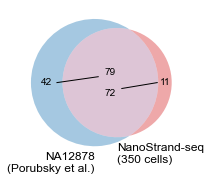

In [18]:
values = [ref_no_hit, que_no_hit, (ref_hit + que_hit) / 2]
plt.figure(figsize=(3, 3))
ret = venn2(values, set_colors=["C0", "C3"], set_labels=["NA12878\n(Porubsky et al.)", "NanoStrand-seq\n(350 cells)"])
ret.subset_labels[2].set_text("%d\n\n%d" % (ref_hit, que_hit))
plt.plot([0.15, 0.45], [-0.05, 0], lw=1, color="black")
plt.plot([-0.4, -0.05], [0, 0.05], lw=1, color="black")
plt.tight_layout()
# plt.show()
plt.savefig("figures/benchmark_of_inversion.nss_cutesv.venn2.pdf", dpi=300)

In [20]:
for inv in invs_merged:
    if inv.hit > 1:
        print(inv.format("BED"))

chr1	146315906	149317235	AnnotatedInversion	.	+	146315906	146315906	0,0,255	1	3001329,	0,
chr10	46884348	47535134	AnnotatedInversion	.	+	46884348	46884348	0,0,255	1	650786,	0,
chr10	47543112	47780339	AnnotatedInversion	.	+	47543112	47543112	0,0,255	1	237227,	0,
chr16	21583279	22476194	AnnotatedInversion	.	+	21583279	21583279	0,0,255	1	892915,	0,
chr17	43299186	43324160	AnnotatedInversion	.	+	43299186	43299186	0,0,255	1	24974,	0,
chr2	130124720	131531814	AnnotatedInversion	.	+	130124720	130124720	0,0,255	1	1407094,	0,
chr5	64467762	64478788	AnnotatedInversion	.	+	64467762	64467762	0,0,255	1	11026,	0,
chr6	26734993	26750063	AnnotatedInversion	.	+	26734993	26734993	0,0,255	1	15070,	0,
chr6	26750063	26766966	AnnotatedInversion	.	+	26750063	26750063	0,0,255	1	16903,	0,


In [10]:
f_bed = "../../4_NanoStrandseq_Assembly/results/HG001_Cell_350/inversions/composites/all_chroms.bed.gz"
with pysam.TabixFile(f_bed) as f:
    for inv in invs_ref:
        c, w = get_c_w_counts(f, inv.chrom, inv.start, inv.end)
        inv.crick = c
        inv.watson = w

In [11]:
for inv in sorted(invs_ref, key=lambda x: len(x)):
    c, w = inv.crick, inv.watson
    r = 0
    if c + w > 0:
        r = w / (c + w)
    loc = "%s:%d-%d" % (inv.chrom, inv.start, inv.end)
    print(inv.name[-3:], len(inv), inv.hit, c, w, "%.2f" % r, loc, sep="\t")

1|0	235	False	7	0	0.00	chr8:102423403-102423638
1|1	266	True	0	0	0.00	chr17:5982838-5983104
1|1	294	True	0	0	0.00	chr5:29069229-29069523
0|1	316	True	2	1	0.33	chr6:89213914-89214230
1|1	335	True	2	0	0.00	chr6:94031360-94031695
1|1	555	True	0	0	0.00	chr21:26001836-26002391
1|1	650	False	0	0	0.00	chr1:43593641-43594291
1|1	662	False	0	1	1.00	chr16:85155339-85156001
1|1	780	False	0	3	1.00	chr3:44699775-44700555
0|1	1095	True	8	3	0.27	chr7:40839776-40840871
0|1	1194	False	2	5	0.71	chrX:153074418-153075612
1|1	1196	False	1	0	0.00	chr4:145693552-145694748
1|0	1197	True	5	5	0.50	chr1:197787659-197788856
1|1	1200	False	0	11	1.00	chr9:113111686-113112886
1|0	1338	False	12	7	0.37	chrX:6219005-6220343
1|0	1400	False	0	7	1.00	chr18:12145103-12146503
1|1	1451	False	0	8	1.00	chr12:12392068-12393519
0|1	1536	False	6	5	0.45	chr11:738649-740185
1|0	1538	False	8	3	0.27	chr12:71546200-71547738
1|1	1674	False	0	9	1.00	chr6:106721331-106723005
0|1	1781	True	8	7	0.47	chrX:14711416-14713197
1|1	1906	False	0	

chr20	28556077	29204924
chr22	11547667	12225587


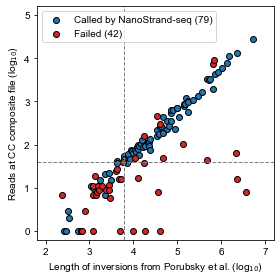

In [61]:
plt.figure(figsize=(4, 4))

xs1, ys1 = [], []
xs2, ys2 = [], []

for inv in sorted(invs_ref, key=lambda x: len(x)):
    c, w = inv.crick, inv.watson
    t = c + w
    r = 0
    if t > 0:
        r = w / t
    gt = inv.name[-3:]
    #if gt != "1|1":
    #    continue
    # color = "C0" if gt == "1|1" else "C3"
    if len(inv) > 100000 and t >= 1000 and (not inv.hit):
        print(inv.chrom, inv.start, inv.end, sep="\t")
    x = np.log10(len(inv))
    y = 0 if t == 0 else np.log10(t)
    if inv.hit:
        xs1.append(x)
        ys1.append(y)
    else:
        xs2.append(x)
        ys2.append(y)
plt.scatter(xs1, ys1, color="C0", edgecolor="black", label="Called by NanoStrand-seq (%d)" % len(xs1))
plt.scatter(xs2, ys2, color="C3", edgecolor="black", label="Failed (%d)" % len(xs2))
plt.axhline(np.log10(40), lw=1, ls="--", color="grey")
plt.axvline(np.log10(6000), lw=1, ls="--", color="grey")
plt.xlabel("Length of inversions from Porubsky et al. (log$_{10}$)")
plt.ylabel("Reads at CC composite file (log$_{10}$)")
plt.xlim(1.8, 7.2)
plt.ylim(-0.2, 5.2)
plt.legend()
plt.tight_layout()
plt.savefig("figures/ref_inv_length_reads.pdf", dpi=300)